Downloading and Extracting the Dataset from Kaggle

In [ ]:
# !mkdir -p ~/.kaggle
# !cp kaggle.json ~/.kaggle/
# !chmod 600 ~/.kaggle/kaggle.json

# !kaggle datasets download -d usefashrfi/iran-used-cars-dataset

# !mkdir -p "/content/drive/MyDrive/vision/project2/carsdata"

# !mv iran-used-cars-dataset.zip "/content/drive/MyDrive/vision/project2/carsdata"

# !unzip -q "/content/drive/MyDrive/vision/project2/carsdata/iran-used-cars-dataset.zip" -d "/content/drive/MyDrive/vision/project2/carsdata"

Dataset URL: https://www.kaggle.com/datasets/usefashrfi/iran-used-cars-dataset
License(s): CC0-1.0


In [9]:
import os
import torch
from pathlib import Path
import cv2
from torchvision import transforms
from tqdm import tqdm
from glob import glob
import matplotlib.pyplot as plt
import pandas as pd
from PIL import Image ,ImageDraw


In [2]:
model_path = '/content/drive/MyDrive/vision/project2/best.pt'
dataset_path = '/content/drive/MyDrive/vision/project2/carsdata/iran-used-cars-dataset'
clahe_dataset_path = '/content/drive/MyDrive/vision/project2/carsdata/CLAHE'
output_labels_path = "/content/drive/MyDrive/vision/project2/carsdata/labels"


In [ ]:
model = torch.hub.load('ultralytics/yolov5', 'custom', path=model_path, force_reload=True)
model = model.to('cuda')
os.makedirs(output_labels_path, exist_ok=True)

Downloading: "https://github.com/ultralytics/yolov5/zipball/master" to /root/.cache/torch/hub/master.zip
YOLOv5 🚀 2025-4-29 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)

Fusing layers... 
Model summary: 308 layers, 21053802 parameters, 0 gradients
Adding AutoShape... 


In [ ]:
#Apply CLAHE only to raw images
for class_folder in tqdm(os.listdir(dataset_path), desc='Applying CLAHE'):
    class_folder_path = os.path.join(dataset_path, class_folder)
    if not os.path.isdir(class_folder_path):
        continue

    clahe_class_folder_path = os.path.join(clahe_dataset_path, class_folder)
    os.makedirs(clahe_class_folder_path, exist_ok=True)

    for img_name in os.listdir(class_folder_path):
        img_path = os.path.join(class_folder_path, img_name)
        clahe_img_path = os.path.join(clahe_class_folder_path, img_name)

        if os.path.exists(clahe_img_path):
            continue

        img = cv2.imread(img_path)
        if img is None:
            continue

        lab = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
        l, a, b = cv2.split(lab)
        l_clahe = clahe.apply(l)
        lab_clahe = cv2.merge((l_clahe, a, b))
        img_clahe = cv2.cvtColor(lab_clahe, cv2.COLOR_LAB2BGR)

        cv2.imwrite(clahe_img_path, img_clahe)


Applying CLAHE: 100%|██████████| 13/13 [00:57<00:00,  4.41s/it]


In [ ]:
#Filtering Unlabeled Images, Running Object Detection, and Saving Annotations
img_paths = []
label_paths = []
img_classes = []
car_class_ids = [0,1,2,3,4]

for class_folder in os.listdir(clahe_dataset_path):
    class_folder_path = os.path.join(clahe_dataset_path, class_folder)
    if not os.path.isdir(class_folder_path):
        continue

    for img_name in os.listdir(class_folder_path):
        img_path = os.path.join(class_folder_path, img_name)
        img_base_name = os.path.splitext(img_name)[0]
        label_file_path = os.path.join(output_labels_path, f'{img_base_name}.txt')

        if os.path.exists(label_file_path):
            continue

        img_paths.append(img_path)
        label_paths.append(label_file_path)
        img_classes.append(class_folder)

for i in tqdm(range(len(img_paths)), desc='Detecting cars'):
    img_path = img_paths[i]
    label_path = label_paths[i]
    class_folder = img_classes[i]

    img = cv2.imread(img_path)
    if img is None:
        continue

    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_resized = cv2.resize(img_rgb, (640, 640))

    results = model(img_resized)
    # results.show()

    detections = results.xyxy[0].cpu().numpy()  # [x1, y1, x2, y2, conf, cls]
    print(f"[{i+1}/{len(img_paths)}] Found {len(detections)} detections")

    car_boxes = []
    for det in detections:
        if int(det[5]) in car_class_ids:
            x1, y1, x2, y2 = det[0], det[1], det[2], det[3]
            width = x2 - x1
            height = y2 - y1
            area = width * height
            car_boxes.append((area, (x1, y1, x2, y2)))

    if not car_boxes:
        continue

    biggest_car = max(car_boxes, key=lambda x: x[0])[1]
    x1, y1, x2, y2 = biggest_car

    os.makedirs(os.path.dirname(label_path), exist_ok=True)
    with open(label_path, 'w') as f:
        f.write(f'{class_folder} {int(x1)} {int(y1)} {int(x2)} {int(y2)}\n')


In [ ]:
text_count = 0
for txt_name in os.listdir(output_labels_path):
    if txt_name.lower().endswith('.txt'):
        text_count += 1

print(f"Total number of label (.txt) files: {text_count}")


Total number of label (.txt) files: 9564


In [ ]:
# Cleaning the Dataset by Deleting Unlabeled Images
all_images = []
no_labels = []
deleted_count = 0

for root, dirs, files in os.walk(clahe_dataset_path):
    for file in files:
        if file.lower().endswith(('.jpg', '.png')):
            img_path = os.path.join(root, file)
            base_name = os.path.splitext(file)[0]
            label_path = os.path.join(output_labels_path, f"{base_name}.txt")

            all_images.append(img_path)
            if not os.path.exists(label_path):
                print(img_path)
                os.remove(img_path)
                deleted_count += 1
print(f"Deleted {deleted_count} images with no valid detections.")



/content/drive/MyDrive/vision/project2/carsdata/CLAHE/Mazda-2000/Mazda-2000 (519).jpg
/content/drive/MyDrive/vision/project2/carsdata/CLAHE/Mazda-2000/Mazda-2000 (272).jpg
/content/drive/MyDrive/vision/project2/carsdata/CLAHE/Mazda-2000/Mazda-2000 (379).jpg
/content/drive/MyDrive/vision/project2/carsdata/CLAHE/Mazda-2000/Mazda-2000 (335).jpg
/content/drive/MyDrive/vision/project2/carsdata/CLAHE/Mazda-2000/Mazda-2000 (134).jpg
/content/drive/MyDrive/vision/project2/carsdata/CLAHE/Mazda-2000/Mazda-2000 (201).jpg
/content/drive/MyDrive/vision/project2/carsdata/CLAHE/Mazda-2000/Mazda-2000 (200).jpg
/content/drive/MyDrive/vision/project2/carsdata/CLAHE/Mazda-2000/Mazda-2000 (561).jpg
/content/drive/MyDrive/vision/project2/carsdata/CLAHE/Mazda-2000/Mazda-2000 (330).jpg
/content/drive/MyDrive/vision/project2/carsdata/CLAHE/Mazda-2000/Mazda-2000 (92).jpg
/content/drive/MyDrive/vision/project2/carsdata/CLAHE/Mazda-2000/Mazda-2000 (10).jpg
/content/drive/MyDrive/vision/project2/carsdata/CLAHE/Ma

Cropping Bounding Boxes from Images and Organizing by Class Labels

In [3]:
!cp -r "/content/drive/MyDrive/vision/project2/carsdata/labels" "/content/labels_local"

In [4]:
dataset_path = '/content/drive/MyDrive/vision/project2/carsdata/iran-used-cars-dataset'
labels_dir ="/content/labels_local"
image_paths = glob(os.path.join(dataset_path, '*', '*.jpg'))

records = []
for img_path in tqdm(image_paths):
    img_name = os.path.splitext(os.path.basename(img_path))[0]
    label_file = os.path.join(labels_dir, f"{img_name}.txt")
    class_folder = os.path.basename(os.path.dirname(img_path))

    with open(label_file, 'r') as f:
        for line in f:
            parts = line.strip().split(' ')
            if len(parts) != 5:
                continue
            label_class, x1, y1, x2, y2 = parts
            records.append({
                'file_path': img_path,
                'class_folder': class_folder,
                'label_class': label_class.strip(),
                'x': float(x1),
                'y': float(y1),
                'width': float(x2) - float(x1),
                'height': float(y2) - float(y1)
            })

df = pd.DataFrame(records)


100%|██████████| 9564/9564 [00:00<00:00, 26484.97it/s]


In [6]:
def crop_image(img_path, bbox, original_width=640, original_height=640):
    img = Image.open(img_path)
    x, y, w, h = bbox

    scale_x = img.width / original_width
    scale_y = img.height / original_height

    x = int(x * scale_x)
    y = int(y * scale_y)
    w = int(w * scale_x)
    h = int(h * scale_y)

    x2 = min(x + w, img.width)
    y2 = min(y + h, img.height)

    return img.crop((x, y, x2, y2))


In [ ]:
cropped_dir = os.path.join("/content/drive/MyDrive/vision/project2/carsdata", 'cropped_data')
os.makedirs(cropped_dir, exist_ok=True)

for class_name in df['label_class'].unique():
    os.makedirs(os.path.join(cropped_dir, class_name), exist_ok=True)

for idx, row in tqdm(df.iterrows(), total=len(df)):
    img_path = os.path.join(dataset_path, 'images', row['file_path'])
    bbox = (row['x'], row['y'], row['width'], row['height'])
    cropped_img = crop_image(img_path, bbox, original_width=640, original_height=640)

    save_path = os.path.join(cropped_dir, row['label_class'], os.path.basename(row['file_path']))
    cropped_img.save(save_path)



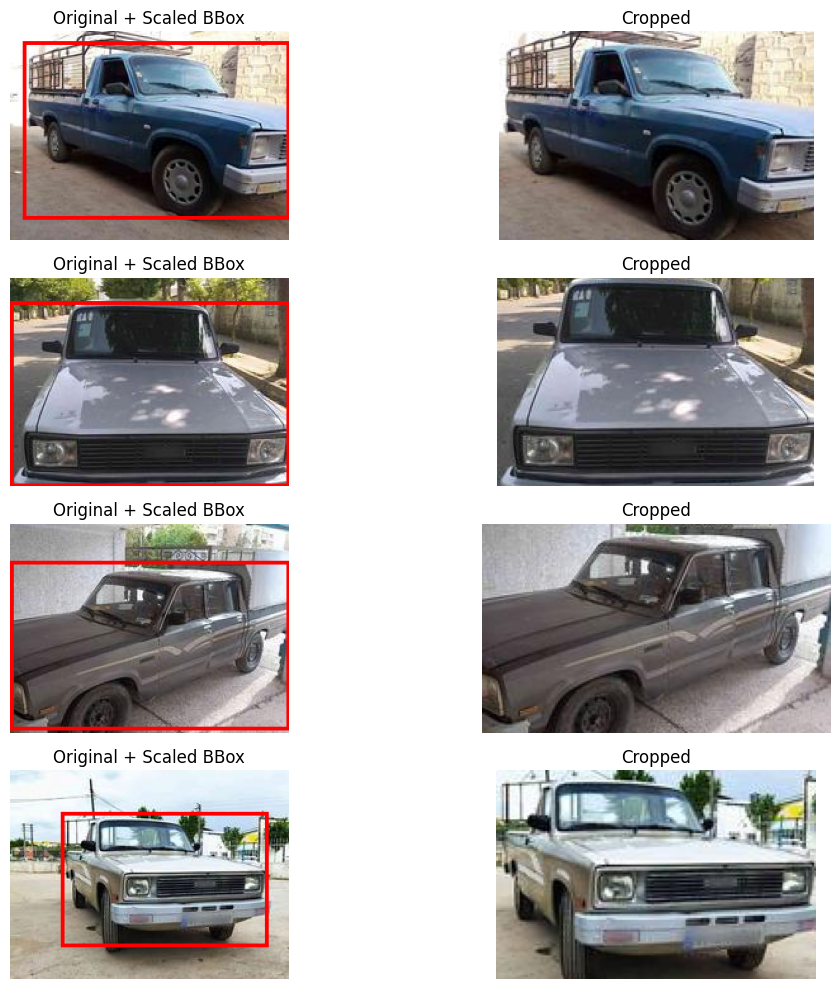

In [10]:
def draw_bbox_on_original(img_path, bbox, original_width=640, original_height=640):
    img = Image.open(img_path).convert("RGB")
    draw = ImageDraw.Draw(img)

    real_width, real_height = img.size

    scale_x = real_width / original_width
    scale_y = real_height / original_height

    x, y, w, h = bbox
    x *= scale_x
    y *= scale_y
    w *= scale_x
    h *= scale_y

    draw.rectangle([x, y, x + w, y + h], outline="red", width=3)
    return img


plt.figure(figsize=(12, 10))
for i in range(4):
    row = df.iloc[i]
    img_path = os.path.join(dataset_path, 'images', row['file_path'])
    bbox = (row['x'], row['y'], row['width'], row['height'])

    img_with_bbox = draw_bbox_on_original(img_path, bbox, original_width=640, original_height=640)

    cropped = crop_image(img_path, bbox, original_width=640, original_height=640)

    plt.subplot(4, 2, i * 2 + 1)
    plt.imshow(img_with_bbox)
    plt.title("Original + Scaled BBox")
    plt.axis("off")

    plt.subplot(4, 2, i * 2 + 2)
    plt.imshow(cropped)
    plt.title("Cropped")
    plt.axis("off")

plt.tight_layout()
plt.show()
